In [1]:
import numpy as np
%load_ext autoreload
%autoreload 2

In [2]:
img_id = "CA184632V0341"

In [3]:
import src.load.load_image as ld

path_data_fld = "C:/Users/Felix/Documents/GitHub/Antarctic_TMA/data/images"
#path_data_fld = "/data_1/ATM/data_1/aerial/TMA/downloaded"

# load image to geo-reference
image = ld.load_image(path_data_fld + "/CA184632V0341.tif")

print(image.shape)

(9522, 10140)


In [4]:
import src.base.connect_to_database as ctd

sql_string = f"SELECT * FROM images WHERE image_id='{img_id}'"
conn = ctd.establish_connection()
data = ctd.execute_sql(sql_string, conn)

azimuth = data.iloc[0]['azimuth']
month = data.iloc[0]['date_month']

azimuth = 360 - azimuth + 90

print(azimuth, month)

sql_string_approx = f"SELECT ST_AsText(footprint_approx) AS footprint_approx FROM images_extracted WHERE image_id='{img_id}'"
data_approx = ctd.execute_sql(sql_string_approx, conn)
footprint_approx = data_approx.iloc[0]['footprint_approx']
print(footprint_approx)

OperationalError: connection to server at "127.0.0.1", port 5432 failed: Connection refused (0x0000274D/10061)
	Is the server running on that host and accepting TCP/IP connections?


In [22]:
mask = np.ones_like(image)
pad_width = 500

mask[:pad_width, :] = 0  # Top edge
mask[-pad_width:, :] = 0  # Bottom edge
mask[:, :pad_width] = 0  # Left edge
mask[:, -pad_width:] = 0  # Right edge

Geo-reference image by satellite
Adjusted image resolution with zoom-factor (0.0884, 0.0859)
Adjusted image resolution with zoom-factor (0.0884, 0.0859)


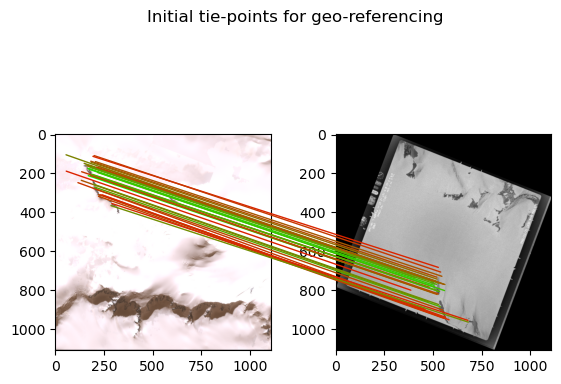

Locate image position
  Check tile 1 (Coords: [-7386, -7380], Order 1)
  0 points were found in this tile.
  Check tile 2 (Coords: [-7386, 0], Order 1)
  0 points were found in this tile.
  Check tile 3 (Coords: [-7386, 7380], Order 1)
  95 points were found in this tile.
  Check tile 4 (Coords: [0, -7380], Order 1)
  0 points were found in this tile.
  Check tile 5 (Coords: [0, 7380], Order 1)
  156 points were found in this tile.
  Check tile 6 (Coords: [7386, -7380], Order 1)
  0 points were found in this tile.
  Check tile 7 (Coords: [7386, 0], Order 1)
  0 points were found in this tile.
  Check tile 8 (Coords: [7386, 7380], Order 1)
  0 points were found in this tile.
  Check tile 9 (Coords: [-14772, -14760], Order 2)
  4 points were found in this tile.
  Check tile 10 (Coords: [-14772, -7380], Order 2)
  13 points were found in this tile.
  Check tile 11 (Coords: [-14772, 0], Order 2)
  0 points were found in this tile.
  Check tile 12 (Coords: [-14772, 7380], Order 2)
  6 point

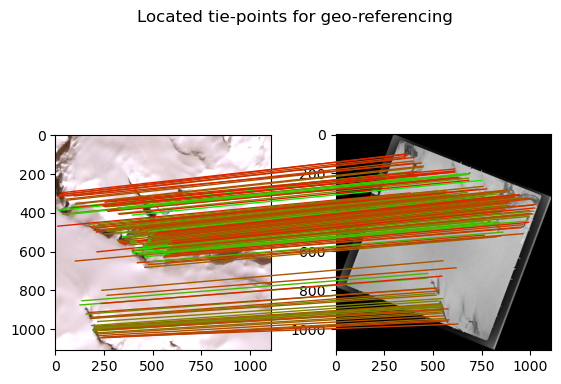

Tweak image position
  Tweak image (1/10) with (176, -977)
  155 points found in tweak 1 of 10
  Points going down (155 < 156)
  Tweak image (2/10) with (-185, -685)
  177 points found in tweak 2 of 10
  Tweak image (3/10) with (190, -303)
  163 points found in tweak 3 of 10
  Points going down (163 < 177)
  Tweak image (4/10) with (84, -329)
  173 points found in tweak 4 of 10
  Points going down (173 < 177)
  Break the loop
Tweaking finished with 177 tie-points


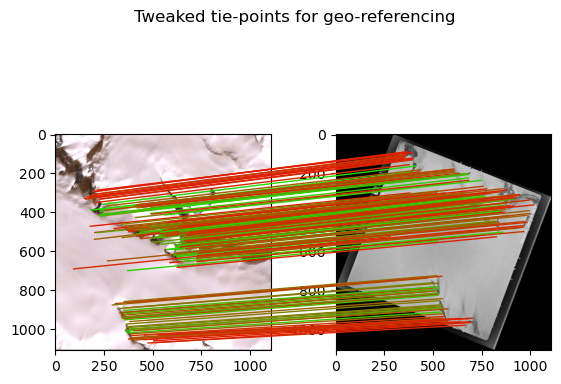

64 outliers removed with RANSAC


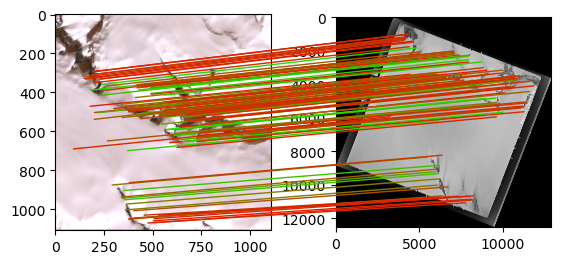

| 0.77, 0.03,-1931708.94|
|-0.00,-0.78, 755249.21|
| 0.00, 0.00, 1.00| 137.5569559787528


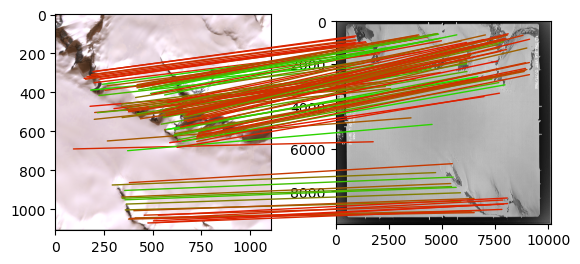

Footprint:
POLYGON ((-1928680.91344089 755152.5842423465, -1928173.370563594 754687.6724381787, -1928586.1808410147 754201.4374236059, -1929093.7237183105 754666.3492277737, -1928680.91344089 755152.5842423465))
Transform:
| 0.73,-0.25,-1928895.03|
|-0.28,-0.73, 755237.28|
| 0.00, 0.00, 1.00|
Residuals:
137.55695597876215


In [36]:
import src.georef.georef_sat as gs

georefSat = gs.GeorefSatellite(enhance_image=False,
                               locate_image=True, tweak_image=True)
footprint, transform, residuals = georefSat.georeference(image, footprint_approx, mask, azimuth, month)

print("Footprint:")
print(footprint)

print("Transform:")
print(transform)

print("Residuals:")
print(residuals)

In [45]:
import src.georef.apply_transform as af
import numpy as np
from rasterio.transform import Affine

#af.apply_transform(image, transform, f"/data_1/ATM/temp/{img_id}.tif")

print(type(transform))

import src.base.rotate_image as ri
img_rotated, _, _ = ri.rotate_image(image, azimuth)

transform_rotated = np.array([[0.77, 0.03,-1931708.94],[-0.00,-0.78, 755249.21], [0.00, 0.00, 1.00]])

a, b, c = transform_rotated[0]
d, e, f = transform_rotated[1]

affine_transform_rotated = Affine(a, b, c, d, e, f)


af.apply_transform(img_rotated, affine_transform_rotated, f"/data_1/ATM/temp/{img_id}_rotated.tif")


<class 'affine.Affine'>
